In [ ]:
# Mount google drive at /content/drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
SETTING = 3
# SETTING = 1 -> Non-Druggable v/s Druggable(Approved+Non-Approved)
# SETTING = 2 -> Non-Druggable + Druggable(Non-Approved) v/s Druggable(Approved)
# SETTING = 3 -> Non-Druggable v/s Druggable(Approved)

In [ ]:
# Setting seeds for reproducibility
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import ADASYN, SMOTE
import pandas as pd
np.random.seed(42)
tf.random.set_seed(42)
import matplotlib.pyplot as plt

In [ ]:
data_file_path = "/content/drive/MyDrive/protein_props/features/protein_props.json"
druggable_proteins_file_path = "/content/drive/MyDrive/protein_props/NEW_WORK/druggable_proteins.txt"
investigational_proteins_file_path = "/content/drive/MyDrive/protein_props/NEW_WORK/investigational_proteins.txt"

with open(data_file_path, 'r') as f:
    protein_data = json.load(f)

print("Total number of uniprot human verified proteins:", len(protein_data))

# Extracting list of druggable and approved druggable proteins
with open(druggable_proteins_file_path, 'r') as f:
    approved_druggable_proteins = f.read().splitlines()

with open(investigational_proteins_file_path, 'r') as f:
    investigational_proteins = f.read().splitlines()

druggable_proteins = approved_druggable_proteins + investigational_proteins

print("Number of druggable proteins:", len(druggable_proteins))
print("Number of druggable approved proteins:", len(approved_druggable_proteins))


# Fetching feature data for all proteins
properties = (pd.read_json("/content/drive/MyDrive/protein_props/features/protein_props.json")).transpose()
is_druggable = [1 if i in druggable_proteins else 0 for i in properties.index]
is_approved_druggable = [1 if i in approved_druggable_proteins else 0 for i in properties.index]

properties["is_druggable"] = is_druggable
properties["is_approved_druggable"] = is_approved_druggable

PCP_properties = properties.copy()
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
amino_acid_percent = {i:[] for i in amino_acids}
for i in PCP_properties['Amino Acid Percent']:
  for aa in amino_acids:
    amino_acid_percent[aa].append(i[aa])
for aa in amino_acids:
  PCP_properties = pd.concat([PCP_properties, pd.Series(amino_acid_percent[aa], index = PCP_properties.index, name = f"Amino Acid Percent {aa}")], axis = 1)

PCP_properties[f"Molar Extinction Coefficient 1"] = pd.Series([x[0] for x in PCP_properties['Molar Extinction Coefficient']], index = PCP_properties.index)
PCP_properties[f"Molar Extinction Coefficient 2"] = pd.Series([x[1] for x in PCP_properties['Molar Extinction Coefficient']], index = PCP_properties.index)

PCP_properties[f"Secondary Structure helix"] = pd.Series([x[0] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)
PCP_properties[f"Secondary Structure turn"] = pd.Series([x[1] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)
PCP_properties[f"Secondary Structure sheet"] = pd.Series([x[2] for x in PCP_properties['Secondary Structure']], index = PCP_properties.index)

PCP_properties.drop(columns = ['Amino Acid Count','Amino Acid Percent',"Molar Extinction Coefficient","Flexibility","Secondary Structure",'Sequence'], inplace = True)
PCP_properties['Sequence Length'] = PCP_properties['Sequence Length'].astype(int)
PCP_properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']] = PCP_properties[['Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7']].astype(float)

with open("/content/drive/MyDrive/protein_props/features/gdpc_encodings.json", 'r') as file:
    data = json.load(file)
gpdc_encodings = pd.DataFrame(data).transpose()

ppi = pd.read_json("/content/drive/MyDrive/protein_props/features/ppi.json").transpose()
ppi_network = pd.read_csv("/content/drive/MyDrive/protein_props/features/ppi_network_properties.csv")
ppi_network.index = ppi_network['Unnamed: 0']
ppi_network.drop(columns = ['Unnamed: 0'], inplace = True)
ppi = pd.concat([ppi, ppi_network], axis = 1)

glycolisation = pd.read_csv("/content/drive/MyDrive/protein_props/features/glycosylation.csv")
glycolisation.index = glycolisation['Unnamed: 0']
glycolisation.drop(columns = ['Unnamed: 0'], inplace = True)
ptm = pd.read_csv("/content/drive/MyDrive/protein_props/features/PTM_counts.csv")
ptm.index = ptm["Unnamed: 0"]
ptm.drop(columns = ['Unnamed: 0'], inplace = True)
ptm_counts = pd.concat([ptm, glycolisation], axis = 1)

with open("/content/drive/MyDrive/protein_props/features/subcellular_locations2.json", 'r') as file:
    data = json.load(file)
unique_groups = set()
for entry in data.values():
    if "general" in entry:
        for general_entry in entry["general"]:
            if "group" in general_entry: unique_groups.add(general_entry["group"])

unique_groups_list = list(unique_groups)

rows = []
for protein_id in PCP_properties.index:
    row = {group: 0 for group in unique_groups_list}
    if protein_id in data:
        for entry in data[protein_id].get("general", []):
            if "group" in entry and entry["group"] in unique_groups:
                row[entry["group"]] = 1
    row["protein_id"] = protein_id
    rows.append(row)

subcellular_data = pd.DataFrame(rows).set_index("protein_id")

domains = pd.read_csv("/content/drive/MyDrive/protein_props/features/data_top20_updated.csv")
domains.index = domains['Unnamed: 0']
domains.drop(columns = ['Unnamed: 0'], inplace = True)

flexibility = pd.read_csv("/content/drive/MyDrive/protein_props/features/flexibility_properties.csv")
flexibility.index = flexibility['Unnamed: 0']
flexibility.drop(columns = ['Unnamed: 0'], inplace = True)

latent_data = pd.read_csv("/content/drive/MyDrive/protein_props/features/latent_values.csv").transpose()
latent_data.columns = [f"Latent_Value_{i+1}" for i in latent_data.columns]
final_data = pd.concat([PCP_properties,gpdc_encodings, ptm_counts, ppi, subcellular_data, domains, flexibility, latent_data], axis = 1).dropna()
features_list = final_data.columns
features_list = features_list.drop(['is_druggable','is_approved_druggable'])
features_list = list(features_list)
print(features_list)
print(len(features_list))


Total number of uniprot human verified proteins: 20434
Number of druggable proteins: 2915
Number of druggable approved proteins: 2233
['Sequence Length', 'Molecular Weight', 'GRAVY', 'Isoelectric Point', 'Instability Index', 'Aromaticity', 'Charge at 7', 'Amino Acid Percent A', 'Amino Acid Percent C', 'Amino Acid Percent D', 'Amino Acid Percent E', 'Amino Acid Percent F', 'Amino Acid Percent G', 'Amino Acid Percent H', 'Amino Acid Percent I', 'Amino Acid Percent K', 'Amino Acid Percent L', 'Amino Acid Percent M', 'Amino Acid Percent N', 'Amino Acid Percent P', 'Amino Acid Percent Q', 'Amino Acid Percent R', 'Amino Acid Percent S', 'Amino Acid Percent T', 'Amino Acid Percent V', 'Amino Acid Percent W', 'Amino Acid Percent Y', 'Molar Extinction Coefficient 1', 'Molar Extinction Coefficient 2', 'Secondary Structure helix', 'Secondary Structure turn', 'Secondary Structure sheet', 'aliphatic_aliphatic', 'aliphatic_positive', 'aliphatic_negative', 'aliphatic_uncharged', 'aliphatic_aromatic',

In [ ]:
# Train Test Splitting
def data_splitting(x_sample, y_sample, mode="default", scaler="none"):
  druggable_indices = (y_sample == 1)  # Assuming 1 represents druggable
  non_druggable_indices = (y_sample == 0)  # Assuming 0 represents non-druggable

  druggable_X = x_sample[druggable_indices]
  druggable_y = y_sample[druggable_indices]

  non_druggable_X = x_sample[non_druggable_indices]
  non_druggable_y = y_sample[non_druggable_indices]

  class_size = 300
  druggable_X_remaining, druggable_X_test, druggable_y_remaining, druggable_y_test = train_test_split(druggable_X, druggable_y, test_size=class_size, random_state=123)
  non_druggable_X_remaining, non_druggable_X_test, non_druggable_y_remaining, non_druggable_y_test = train_test_split(non_druggable_X, non_druggable_y, test_size= class_size, random_state=123)

  X_test = pd.concat((druggable_X_test, non_druggable_X_test))
  y_test = pd.concat((druggable_y_test, non_druggable_y_test))
  X_train = pd.concat((druggable_X_remaining, non_druggable_X_remaining))
  y_train = pd.concat((druggable_y_remaining, non_druggable_y_remaining))
  X_train, y_train = shuffle(X_train, y_train, random_state=123)
  if mode == "default":
    pass
  elif mode == "adasyn":
    ada = ADASYN(random_state=42)
    X_train, y_train = ada.fit_resample(X_train, y_train)
  elif mode == "smote":
    smt = SMOTE(random_state=42)
    X_train, y_train = smt.fit_resample(X_train, y_train)

  if scaler == "std":
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  elif scaler == "minmax":
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  elif scaler == "none":
    pass

  return X_train, X_test, y_train, y_test


In [ ]:
# rem-new-data is to extract only those proteins which are either approved druggable or non-druggable
# i.e., it excludes proteins which are non-approved but druggable
new_data = final_data.copy()
new_data['new_column'] = new_data['is_druggable'] + new_data['is_approved_druggable']
rem_new_data = new_data[new_data['new_column'] != 1]
rem_new_data.shape, np.bincount(rem_new_data['new_column'])

((19596, 186), array([17377,     0,  2219]))

In [ ]:
if SETTING == 1:
  X_train, X_test, y_train, y_test = data_splitting(final_data[features_list], final_data['is_druggable'])
elif SETTING == 2:
  X_train, X_test, y_train, y_test = data_splitting(final_data[features_list], final_data['is_approved_druggable'])
elif SETTING == 3:
  X_train, X_test, y_train, y_test = data_splitting(rem_new_data[features_list], rem_new_data['is_druggable'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18996, 183), (600, 183), (18996,), (600,))

In [ ]:
import numpy as np
np.bincount(y_train), np.bincount(y_test)

(array([17077,  1919]), array([300, 300]))

### Feature Selection Scores using the partition Method

In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# # On entire data
# X_combined = np.concatenate((X_train, X_test))
# y_combined = np.concatenate((y_train, y_test))

# # shuffling
# X_combined, y_combined = shuffle(X_combined, y_combined, random_state=123)
# X_combined.shape, y_combined.shape

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### Feature Scores using Partition Method of Train Data using several RF models

In [ ]:
X_train_druggable = X_train[y_train == 1]
X_train_non_druggable = X_train[y_train == 0]
number_partitions = round(X_train_non_druggable.shape[0]/X_train_druggable.shape[0])
X_train_non_druggable_partitions = np.array_split(X_train_non_druggable, number_partitions)

print("Number of partitions:", len(X_train_non_druggable_partitions))
for partition in X_train_non_druggable_partitions:
  print(partition.shape)

Number of partitions: 9
(1898, 183)
(1898, 183)
(1898, 183)
(1898, 183)
(1897, 183)
(1897, 183)
(1897, 183)
(1897, 183)
(1897, 183)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

def calculate_feature_scores(seed):
  rf_models = []
  for i, partition in enumerate(X_train_non_druggable_partitions):
    X_train_new = np.concatenate((X_train_druggable, partition))
    y_train_new = np.concatenate((np.ones(X_train_druggable.shape[0]), np.zeros(partition.shape[0])))
    X_train_new, y_train_new = shuffle(X_train_new, y_train_new, random_state=seed)
    rf_model_fs2 = RandomForestClassifier(random_state=seed)
    rf_model_fs2.fit(X_train_new, y_train_new)
    rf_models.append(rf_model_fs2)
  mean_feature_importances = np.mean([model.feature_importances_ for model in rf_models], axis=0)
  return rf_models, mean_feature_importances

rf_models, mean_feature_importances = calculate_feature_scores(seed=42)
len(rf_models)

9

In [ ]:
!pip install shap
import shap

In [ ]:
import shap
explainers = []
for model in rf_models:
  explainer = shap.TreeExplainer(model)
  explainers.append(explainer)

shap_values_test = []
i = 0
for explainer in explainers:
  print(i)
  i += 1
  shap_values_test.append(explainer.shap_values(X_test))

0
1
2
3
4
5
6
7
8


In [ ]:
for i in range(len(shap_values_test)):
  print(shap_values_test[i].shape)

(600, 183, 2)
(600, 183, 2)
(600, 183, 2)
(600, 183, 2)
(600, 183, 2)
(600, 183, 2)
(600, 183, 2)
(600, 183, 2)
(600, 183, 2)


In [ ]:
mean_shap_values = np.mean(shap_values_test, axis=0)
mean_shap_values.shape

(600, 183, 2)

In [ ]:
feature_list = [59, 143, 31, 4, 52, 149, 154, 2, 20, 14]

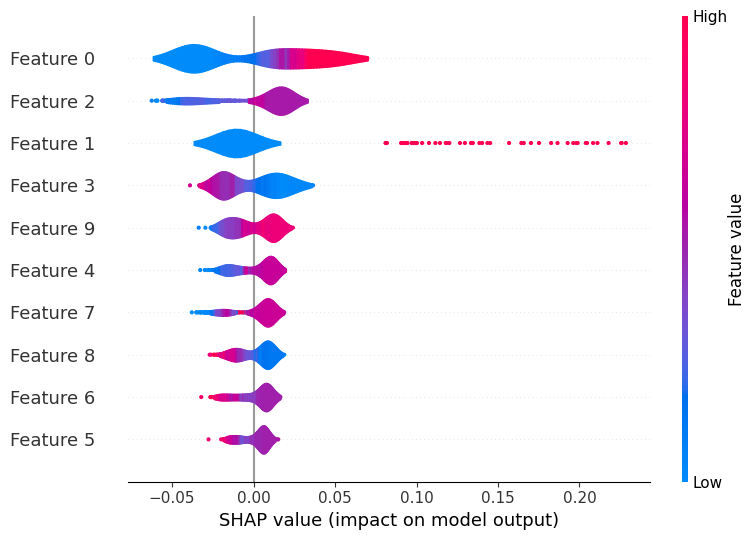

In [ ]:
shap.summary_plot(mean_shap_values[:,feature_list,0], X_test[:,feature_list], plot_type="violin", show=False)

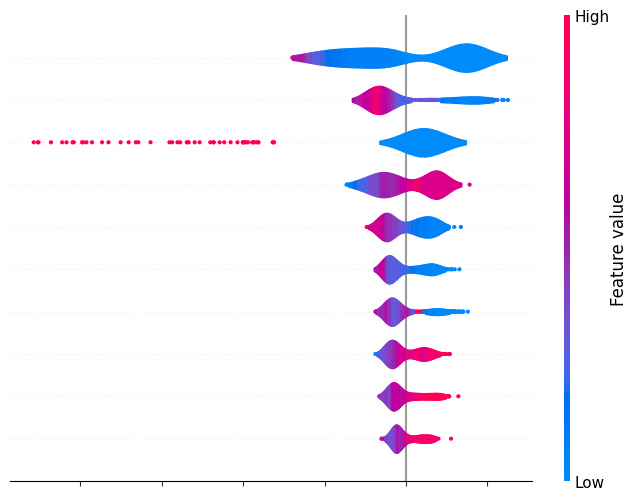

In [ ]:
shap.summary_plot(mean_shap_values[:,feature_list,0], X_test[:,feature_list], plot_type="violin", show=False)
plt.gca().set_xticklabels([])
plt.gca().set_xlabel('')
plt.gca().set_yticklabels([])
plt.savefig("RF_train_shap.png")